In [4]:
# from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skfuzzy as fuzz
from scipy.sparse.linalg import svds

cos, sin = np.cos, np.sin
twopi = np.pi*2.0
halfL = 0.5

In [2]:
def plotLine(x1,y1,x2,y2,c='b',ax=None):
    if ax: # given axis handle
        ax.plot([x1, x2], [y1, y2], color=c, linestyle='-', linewidth=0.5);
    else:
        plt.gca().plot([x1, x2], [y1, y2], color=c, linestyle='-', linewidth=0.5);

In [156]:
fname = "/home/michael/msc/mcmd/bigbox1"

iSnap = 20

# Count num blocks
Nblock = 0
dfile = open(fname, "r")
for line in dfile.readlines():
    if line == "\n": Nblock+=1
dfile.seek(0)
if iSnap == -1: iSnap = Nblock-1

ln = dfile.readline().split("|")
nrod = 0
edge = 0.
for s in ln:
    if "boxEdge" in s:
        edge = float(s.split()[1])
    if "nObj" in s:
        nrod = int(s.split()[1])
dfile.seek(0)
ndim = 3 # x,y,c2th
data = np.zeros(shape=(nrod,ndim))
thetas = np.zeros(shape=(nrod,))
ncenters = 2

if not (dfile.readline()[0].isalpha()): dfile.seek(0)
cntSnap = 0

i = 0
for line in dfile.readlines():
    if cntSnap == iSnap:
        if line == "\n" or line.startswith("label"): break
        l = [float(x) for x in line.split()]
        x,y,th = l[2],l[3],l[4]
        x = (x+edge/2.)/edge
        y = (y+edge/2.)/edge
        c2th = cos(th)*cos(th)
#         th /= twopi
        data[i] = np.asarray([x,y,c2th])
        thetas[i] = th
        i+=1
    else: 
        if line == "\n": cntSnap+=1

dfile.close()

In [163]:
#
# Run fuzzy clustering method
#

# Hopefully two centers representing jam and good flow
# centers = [np.asarray([21, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
#            np.asarray([9, 6, 1, 1, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 0])]


# U,S,V = svds(data,k=reduced_dim)
# data_svd = U.dot(np.diag(S))  # output of TruncatedSVD
# raw_approx = data_svd.dot(V)

fpcs = []
for ncntr in range(3,4):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data.T, ncntr, 2, error=0.000001, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)
    print fpc
    
print ncenters, p, fpc

0.630507543063
2 41 0.630507543063


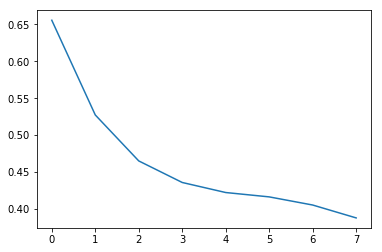

In [141]:
plt.plot(fpcs)

In [124]:
print data.shape, u.shape, cntr.shape

(3600, 4) (2, 3600) (2, 4)


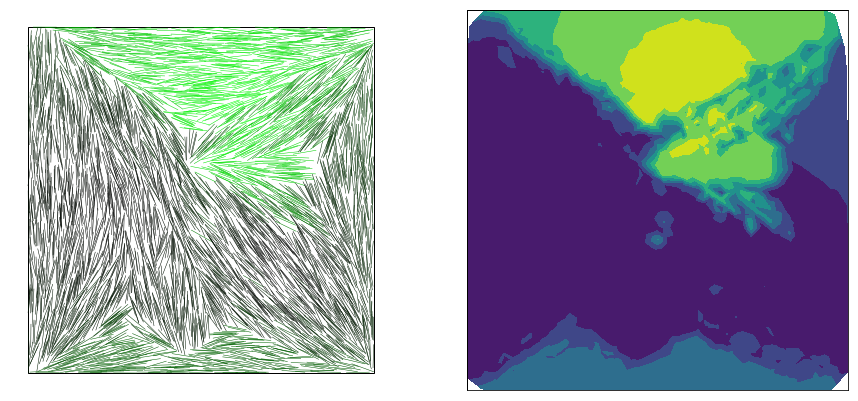

In [165]:
# To view a single unprocessed snap
f,ax = plt.subplots(1,2,figsize=(15,7));

uc = 0 # select which feature of u

bSave = 0

i = 0
minth = min(data[:,2])
maxth = max(data[:,2])

for r in data:
    x,y,c2th = r[0],r[1],r[2]
    th = thetas[i]
    x *= edge
    y *= edge
    
    # Note th=0 is along the y-axis
    x1 = x - halfL*sin(th)
    y1 = y + halfL*cos(th)
    x2 = x + halfL*sin(th)
    y2 = y - halfL*cos(th)
    
#     c = (0.,(costh+1)/2.,0.)
    c = (0.,u.T[i][uc],0.)
    i+=1
    
    plotLine(x1,y1,x2,y2,c,ax=ax[0]);

xs = [d[0]*edge for d in data]
ys = [d[1]*edge for d in data]
ax[1].tricontourf(xs,ys,u[uc,:],)

radius = edge/2.
# ax[1].xlim=(-radius,radius)
# ax[1].ylim=(-radius,radius)

for A in ax:
    A.set_xticks([]);
    A.set_yticks([]);

    boundary = plt.Rectangle((0,0),edge,edge,color='k',fill=False);
#     plt.gca().add_artist(boundary);
#     plt.gca().set_axis_off()
    A.add_artist(boundary);
ax[0].set_axis_off()

if bSave:
    f.savefig(imgdir+imgname+"_"+str(iSnap)+".eps")
#         f.savefig(imgdir+imgname+"_"+str(iSnap)+".eps",pad_inches=0,bbox_inches='tight')

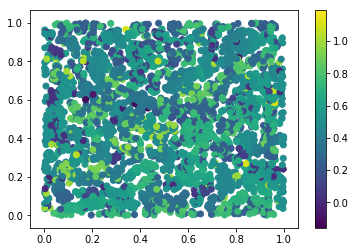

In [84]:
plt.scatter(x,y,c=th)
plt.colorbar()

In [43]:
img.shape

(3600, 3)

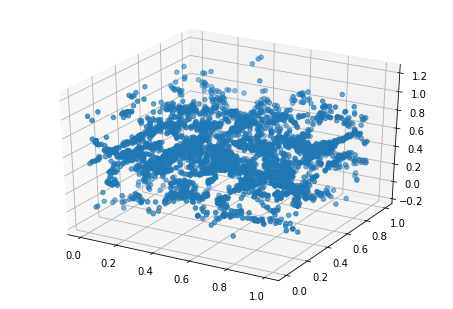

In [83]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

img = get_img_batch(1,1)[0]
skips = 1
x,y,th = img[:,0][::skips], img[:,1][::skips], img[:,2][::skips]
args = np.argwhere(x>0.)
args = np.argwhere(y[args]>0.)
ax.scatter(x[args],y[args],th[args])

In [51]:
# Count num blocks
# fname = "/home/michael/msc/mcmd/bigbox1"
fname = "/home/michael/msc/mcmd/X_0"
Nblock = 0
dfile = open(fname, "r")
for line in dfile.readlines():
    if line == "\n": Nblock+=1
dfile.seek(0)

ln = dfile.readline().split("|")
nrod = 0
edge = 0.
for s in ln:
    if "boxEdge" in s:
        edge = float(s.split()[1])
    if "nObj" in s:
        nrod = int(s.split()[1])
dfile.seek(0)
ndim = 3 # x,y,th
ncenters = 3

cntSnap = 0

i = 0

def get_img_batch(start,batchsize):
    # start is which img to start at
    databatch = []
    
    dfile = open(fname,'r')
    if not (dfile.readline()[0].isalpha()): dfile.seek(0)
        
    iSnap = start
    endsnap = start+batchsize
    if endsnap >= Nblock:
        endsnap = endsnap - Nblock
    snaps = []
    i = 0
    while i < batchsize:
        if iSnap == Nblock:
            iSnap = 1
        snaps.append(iSnap)
        iSnap += 1
        i += 1
    iSnap = start
    
    cntSnap = 0
    data = np.zeros(shape=(nrod,ndim))
    i = 0
    for line in dfile.readlines():        
        if cntSnap == 0:
            if line == "\n": cntSnap+=1
            continue
        if cntSnap == Nblock:
            dfile.seek(0)
            if not (dfile.readline()[0].isalpha()): dfile.seek(0)
            cntSnap = 0
        if cntSnap in snaps:
            if line == "\n" or line.startswith("label"): 
                databatch.append(data)
                data = np.zeros(shape=(nrod,ndim))
                cntSnap += 1
                i = 0
                continue
            l = [float(x) for x in line.split()]
            x,y,th = l[2],l[3],l[4]
            x = (x+edge/2.)/edge
            y = (y+edge/2.)/edge
            th /= twopi
            data[i] = np.asarray([x,y,th])
            i+=1
        else: 
            if line == "\n": cntSnap+=1

    dfile.close()
    
    return np.asarray(databatch)

In [6]:
# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')


In [34]:
B = get_img_batch(2,10)

In [35]:
B.shape

(10, 3600, 3)

In [12]:
X[0]

array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
        15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
         8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
         5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
         1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
         0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.], dtype=float32)

In [14]:
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# Models we will use
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 128
logistic.C = 6000

# Training RBM-Logistic Pipeline
X_train = get_img_batch(2,100)
X_test = get_img_batch(Nblock-11,10)
rbm_features_classifier.fit(X_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train)

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
# print("Logistic regression using RBM features:\n%s\n" % (
#     metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
# print("Logistic regression using raw pixel features:\n%s\n" % (
#     metrics.classification_report(Y_test, Y_pred)))

ValueError: Found array with dim 3. Estimator expected <= 2.